# Plot Climdex Data from Catalog

We will open the climdex catalog and make a plot of all available `TG` indices for historical and scenario time periods. We use a dask scheduler to speed up the processing. This notebook is loosely based on the [CMIP6 global temperature pangeo example](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/global_mean_surface_temp.html).

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'






/work/ch0636/g300046/conda_envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [2]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = SLURMCluster(name='dask-scheduler',
                       cores=4,                # Total number of cores per job
                       memory='16GB',          # Total amount of memory per job
                       processes=4,            # Number of Python processes per job
                       interface='ib0',        # Network interface to use like eth0 or ib0
                       queue='shared',      
                       project='ch0636',     
                       walltime='12:00:00',
                       asynchronous=0)
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p shared
#SBATCH -A ch0636
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=15G
#SBATCH -t 12:00:00

/work/ch0636/g300046/conda_envs/dask/bin/python -m distributed.cli.dask_worker tcp://10.50.40.132:39729 --nthreads 1 --nprocs 4 --memory-limit 4.00GB --name name --nanny --death-timeout 60 --interface ib0



/work/ch0636/g300046/conda_envs/dask/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41348 instead
  http_address["port"], self.http_server.port


In [3]:
client = Client(cluster)
client

Client Scheduler: tcp://10.50.40.132:39729 Dashboard: /user/g300046/advanced//proxy/41348/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
cluster.scale(64)

## Access data

Now we can open the catalog file and make a quick overview of the content...

In [7]:
import intake
%matplotlib
url = "/work/ch0636/intake-esm/intake-esm-datastore/catalogs/climdex-cmip5.json"
cat = intake.open_esm_datastore(url)
cat

Using matplotlib backend: agg


,unique
CIName,15
frequency,1
model,40
experiment,4
ensemble_member,20
CIInstitution,1
CIFrequency,2
temporal_subset,54
path,8020


In [10]:
# check out which indices are available...
cat.unique()['CIName']

{'count': 15,
 'values': ['CDD',
  'FD',
  'R10mm',
  'R20mm',
  'RRm',
  'RX1day',
  'RX5day',
  'SDII',
  'SU',
  'TG',
  'TNn',
  'TNx',
  'TR',
  'TXn',
  'TXx']}

Now let's get a subset of the data. We want the `TG` index and for all experiment ids.

In [11]:
expts = ['historical', 'rcp26', 'rcp45', 'rcp85']
# require_all_on means we want only those models for which all experiment ids are available.
subset = cat.search(CIName='TG', experiment=expts, CIFrequency='year', ensemble_member='r1i1p1', require_all_on='model')

subset.df.groupby("model")[
    ["experiment", "CIName"]
].nunique()

,experiment,CIName
model,,
BNU-ESM,4,1
CCSM4,4,1
CESM1-CAM5,4,1
CNRM-CM5,4,1
CSIRO-Mk3-6-0,4,1
CanESM2,4,1
GFDL-CM3,4,1
GFDL-ESM2G,4,1
GFDL-ESM2M,4,1


## Process data

Let's define some helper functions. Instead of using `to_dataset_dict`, we open from the dataframe `path` attribute so we can open in parallel.

In [42]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def open_dset(df):
    #assert len(df) == 1
    ds = xr.open_mfdataset(df.agg('path').values, use_cftime=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    return ds.mean(dim=('lon', 'lat'))

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in subset.df.groupby(by=['model', 'experiment']):
    dsets[group[0]][group[1]] = open_delayed(df)

Now, trigger the parallel opening of the datasets. We get a dictionary with the `model` and `experiment` attributes as keys.

In [43]:
dsets_ = dask.compute(dict(dsets))[0]

In [44]:
dsets_.keys()

dict_keys(['BNU-ESM', 'CCSM4', 'CESM1-CAM5', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'HadGEM2-ES', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M', 'bcc-csm1-1', 'bcc-csm1-1-m'])

Check out `MPI-ESM-LR` example dataset..

In [45]:
dsets_['MPI-ESM-LR']['historical']

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 192, time: 156)
Coordinates:
  * time       (time) object 1850-07-02 12:00:00 ... 2005-07-02 12:00:00
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(156, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
    TG         (time, lat, lon) float32 dask.array<chunksize=(156, 96, 192), meta=np.ndarray>
Attributes:
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.4
    history:                Sat Sep 05 03:06:14 2020: cdo -O -setname,TG /wor...
    source:                 MPI-ESM-LR 2011; URL: http://svn.zmaw.de/svn/cosm...
    institution:            Max Planck Institute for Meteorology
    institute_id:           MPI-M
    experiment_id:          historical
    model_id:               MPI-ESM-LR
    forcing:                GHG Oz SD Sl Vl LU
    parent_experiment_id:   piControl
    parent_experiment_rip:  r1i1p1
    branch_time:            10957.0
    contact:                cmip5-mpi-esm@dkrz.de
    references:             ECHAM6: n/a; JSBACH: Raddatz et al., 2007. Will t...
    initialization_method:  1
    physics_version:        1
    tracking_id:            ebc1bdaa-9240-42d1-a5da-93e049ff0810
    product:                output
    experiment:             historical
    frequency:              year
    creation_date:          2011-05-27T17:18:56Z
    project_id:             CMIP5
    table_id:               Table day (27 April 2011) 86d1558d99b6ed1e7a886ab...
    title:                  MPI-ESM-LR model output prepared for CMIP5 histor...
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.5.9
    ci_creation_date:       2020-09-05T03:06:14Z
    ci_contact:             gerics-cordex@hzg.de
    ci_institution:         Helmholtz-Zentrum Geesthacht, Climate Service Cen...
    ci_institute_id:        GERICS-climdex-v1.0
    ci_name:                TG
    ci_package_name:        Climate Data Operators version 1.9.8 (https://mpi...
    ci_product:             gcm_derived
    ci_frequency:           year

Ok, that seemed to work. Now we want to align the datasets along the experiment id. That means we will combine all experiments for a model into one dataset along an `experiment` coordinate. This seems to be common practice with xarray and dask because it make analysis and plotting really convenient. E.g, no reason to *merge* data along the time axis, we can just plot that data on top of each other. We also replace the time axis with simple year values (it's annual mean after all), because otherwise we get in trouble with all kinds of different calendars from the models.

In [46]:
expt_da = xr.DataArray(expts, dims='experiment', name='experiment',
                       coords={'experiment': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    print(k)
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds['time'] = [date.year for date in ds.time.values]
    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_global_mean = [v[expt].pipe(global_mean)
                      for expt in expts]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_global_mean, join='outer',
                                 dim=expt_da)

BNU-ESM
CCSM4
CESM1-CAM5
CNRM-CM5
CSIRO-Mk3-6-0
CanESM2
GFDL-CM3
GFDL-ESM2G
GFDL-ESM2M
HadGEM2-ES
IPSL-CM5A-LR
IPSL-CM5A-MR
MIROC-ESM
MIROC-ESM-CHEM
MIROC5
MPI-ESM-LR
MPI-ESM-MR
MRI-CGCM3
NorESM1-M
bcc-csm1-1
bcc-csm1-1-m



We have now aligned the dictionary's `experiment` key into an xarray coordinate:

In [47]:
dsets_aligned['MPI-ESM-LR']

<xarray.Dataset>
Dimensions:     (bnds: 2, experiment: 4, time: 451)
Coordinates:
  * experiment  (experiment) <U10 'historical' 'rcp26' 'rcp45' 'rcp85'
  * time        (time) int64 1850 1851 1852 1853 1854 ... 2297 2298 2299 2300
    height      float64 2.0
Dimensions without coordinates: bnds
Data variables:
    lon_bnds    (experiment, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds    (experiment, bnds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    TG          (experiment, time) float32 dask.array<chunksize=(1, 451), meta=np.ndarray>

Now, let's trigger the computation!

In [48]:
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]



Finally, let's combine all model datasets into one big dataset. The model id will also become an xarray coordinate!

In [49]:
models = list(dsets_aligned_.keys())
model_da = xr.DataArray(models, dims='model', name='model',
                         coords={'model': models})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=model_da)

big_ds

<xarray.Dataset>
Dimensions:     (bnds: 2, experiment: 4, model: 21, time: 451)
Coordinates:
  * model       (model) <U14 'BNU-ESM' 'CCSM4' ... 'bcc-csm1-1' 'bcc-csm1-1-m'
  * time        (time) int64 1850 1851 1852 1853 1854 ... 2297 2298 2299 2300
  * experiment  (experiment) <U10 'historical' 'rcp26' 'rcp45' 'rcp85'
Dimensions without coordinates: bnds
Data variables:
    lon_bnds    (model, experiment, bnds) float64 177.2 180.0 ... 178.9 180.0
    lat_bnds    (model, experiment, bnds) float64 -1.373 1.373 ... 0.5571
    TG          (model, experiment, time) float32 nan nan nan ... nan nan nan

## Plot data

We have now all global mean `TG` indices for all experiment ids and models in one big xarray dataset. Now, we can easily process the data further and make plots!

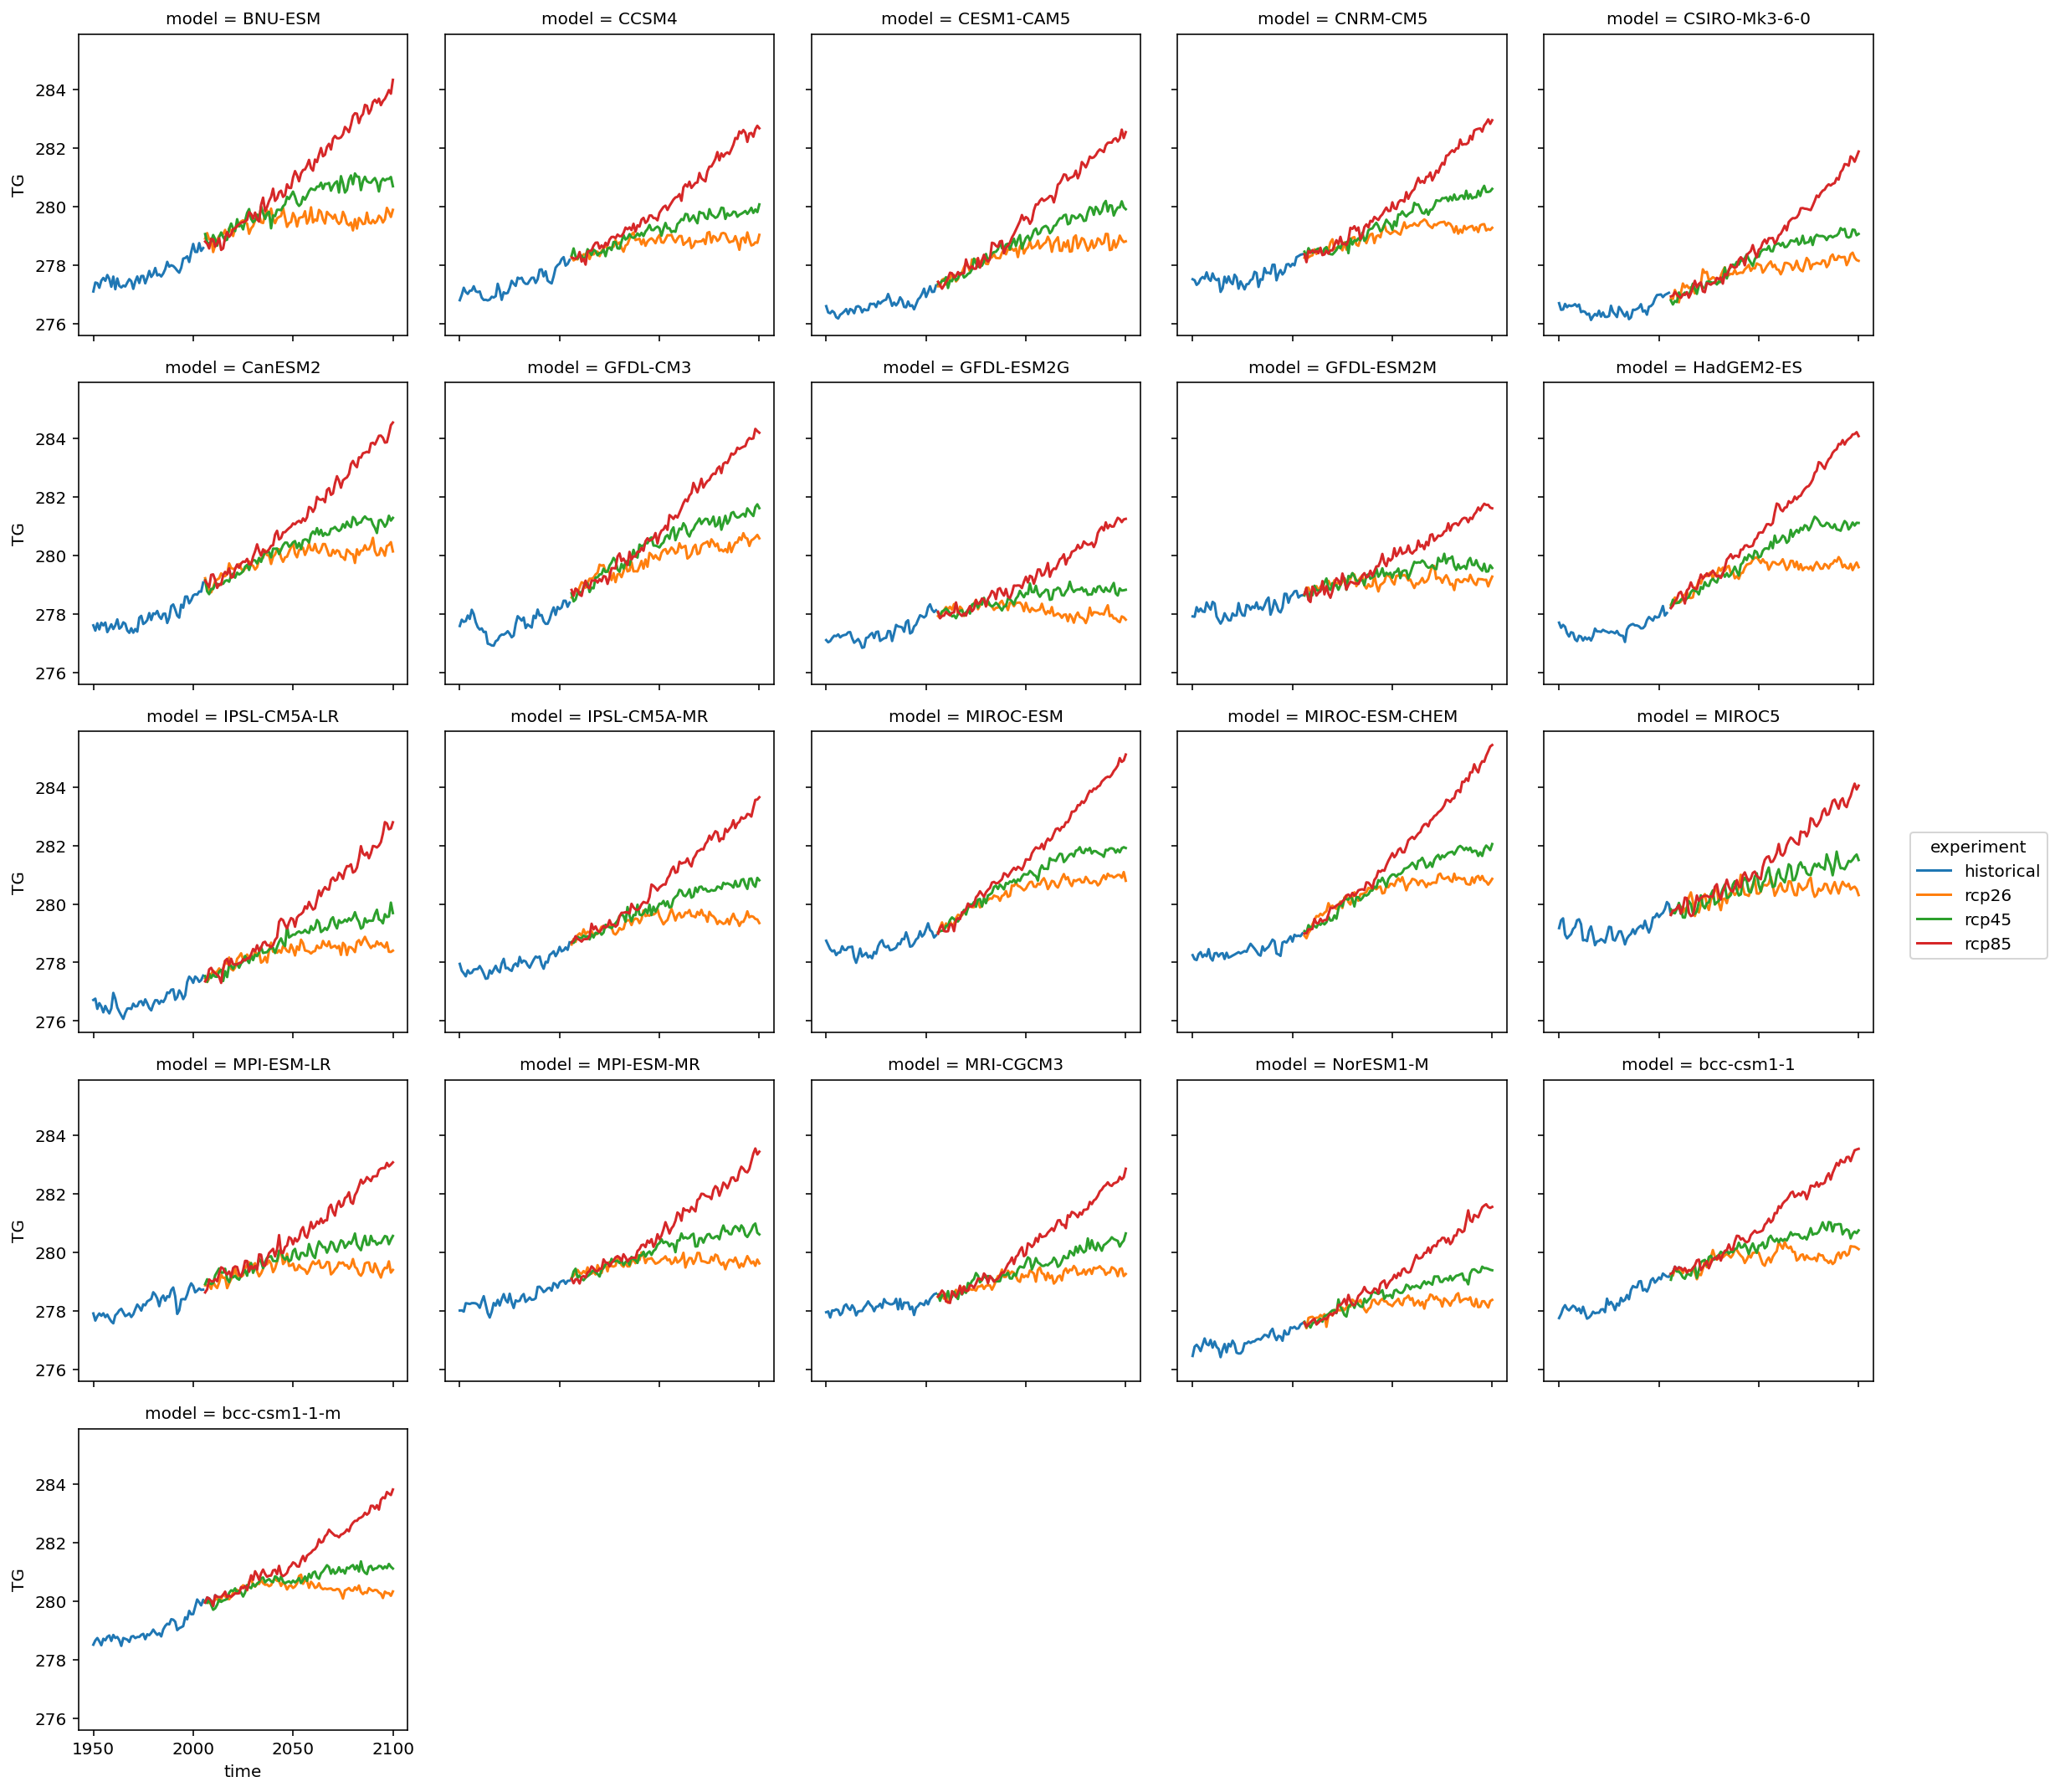

In [50]:
# create a line plot for each model id!
big_ds.TG.sel(time=slice(1950,2100)).plot.line(col='model', x='time', col_wrap=5)

Since we have reduced the spatical dimensions, we can convert the dataset easily to a pandas dataframe and use the nice plotting capabilities of seaborn!

In [72]:
df_all = big_ds.sel(time=slice(1900, 2100)).to_dataframe().reset_index()
df_all.head()

,bnds,experiment,model,time,lon_bnds,lat_bnds,TG
0,0,historical,BNU-ESM,1900,177.1875,-1.372872,NaN
1,0,historical,BNU-ESM,1901,177.1875,-1.372872,NaN
2,0,historical,BNU-ESM,1902,177.1875,-1.372872,NaN
3,0,historical,BNU-ESM,1903,177.1875,-1.372872,NaN
4,0,historical,BNU-ESM,1904,177.1875,-1.372872,NaN


Finally, let's plot the ensemble mean and 95th percentile.

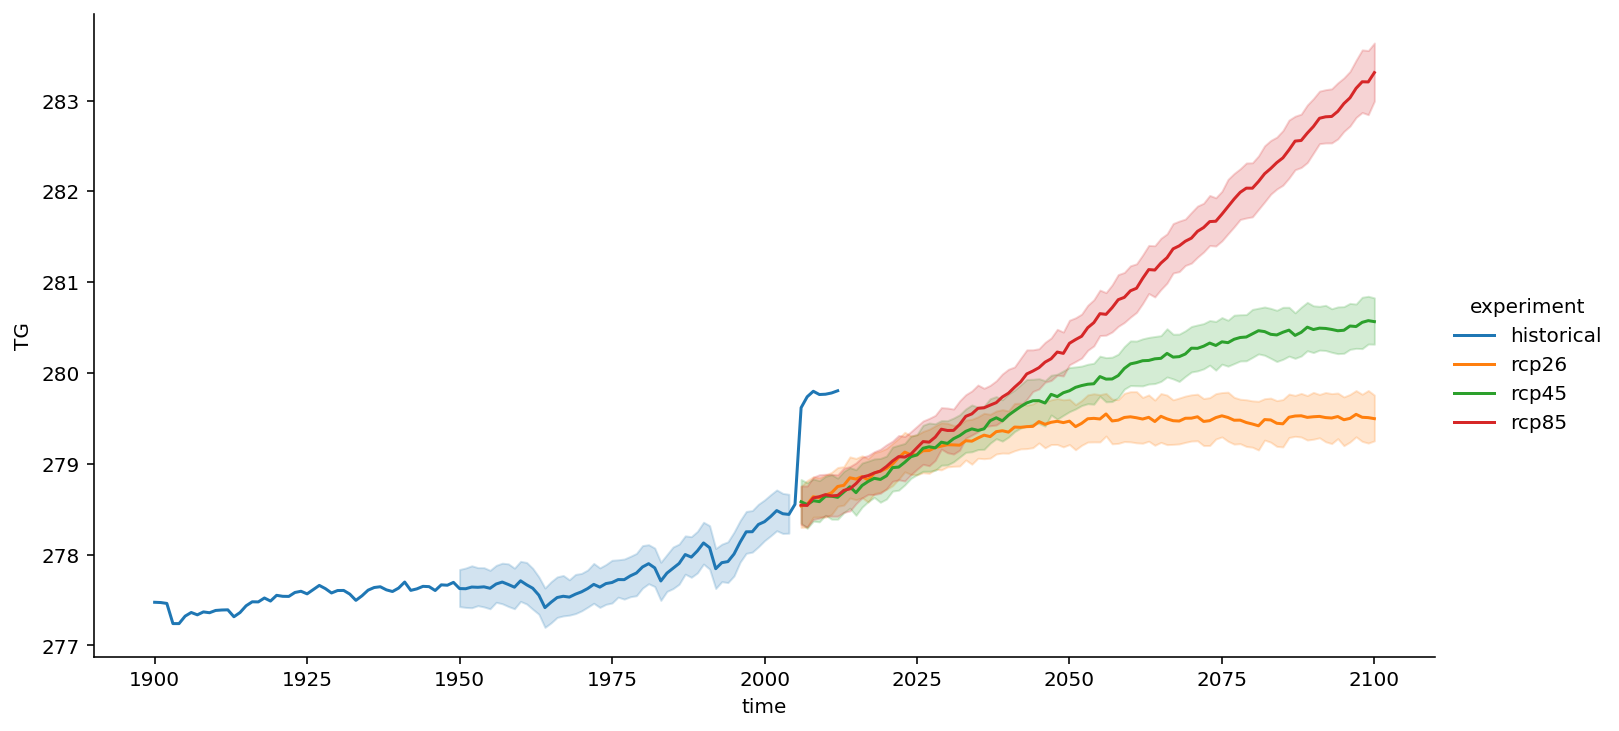

In [59]:
sns.relplot(data=df_all,
            x="time", y="TG", hue='experiment',
            kind="line", ci=95, aspect=2);

In [64]:
df_hist = df_all[df_all['experiment'] == 'historical']

,bnds,experiment,model,time,lon_bnds,lat_bnds,TG
0,0,historical,BNU-ESM,1900,177.1875,-1.372872,NaN
1,0,historical,BNU-ESM,1901,177.1875,-1.372872,NaN
2,0,historical,BNU-ESM,1902,177.1875,-1.372872,NaN
3,0,historical,BNU-ESM,1903,177.1875,-1.372872,NaN
4,0,historical,BNU-ESM,1904,177.1875,-1.372872,NaN
...,...,...,...,...,...,...,...
21100,1,historical,bcc-csm1-1-m,2096,180.0000,0.557134,NaN
21101,1,historical,bcc-csm1-1-m,2097,180.0000,0.557134,NaN
21102,1,historical,bcc-csm1-1-m,2098,180.0000,0.557134,NaN
21103,1,historical,bcc-csm1-1-m,2099,180.0000,0.557134,NaN


The outliers in the historical period around 2005 come from a few models where the historical period seems to span longer periods. Let's check that out!

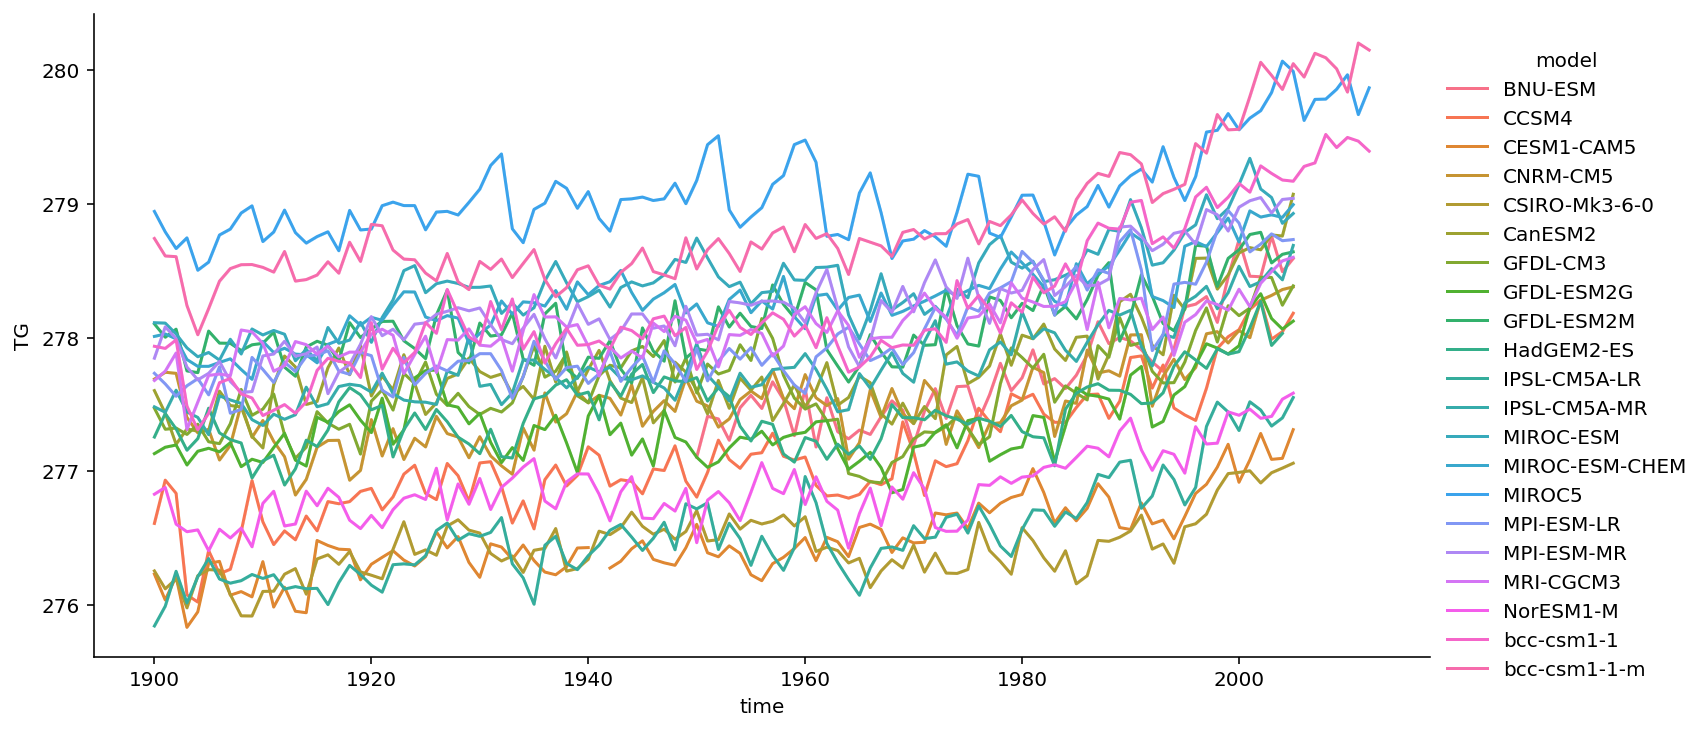

In [65]:
sns.relplot(data=df_hist, x="time",
            y="TG", hue='model',
            kind="line", aspect=2)

In [87]:
sel_rows = df_all.loc[(df_all.experiment == 'historical') & (df_all.time > 2005)].index
df_clean = df_all.drop(sel_rows, axis=0)

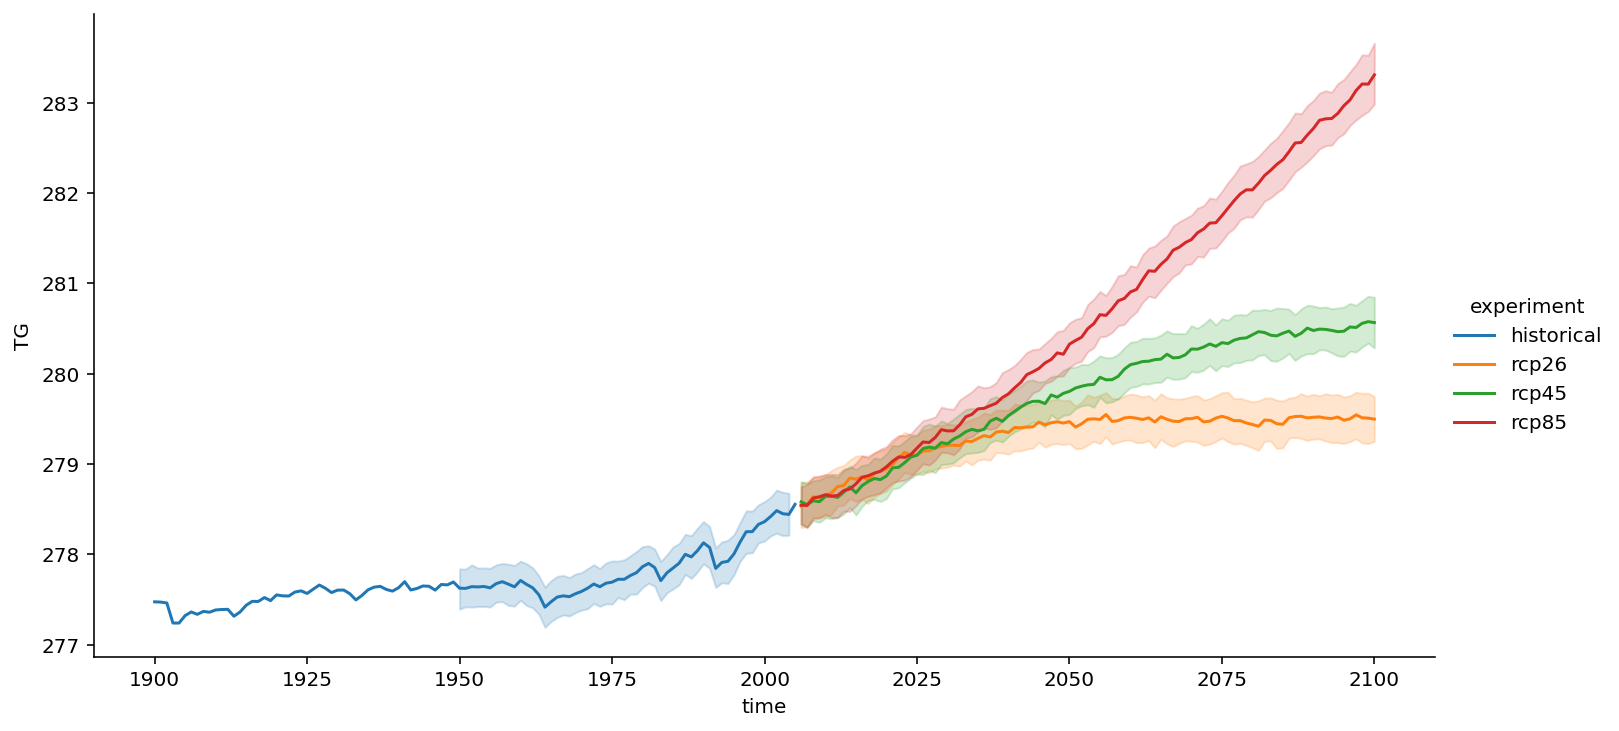

In [88]:
sns.relplot(data=df_clean,
            x="time", y="TG", hue='experiment',
            kind="line", ci=95, aspect=2);